In [1]:
import random
import numpy as np
import math
import time

from numba import jit,prange

from helper_functions import *
from deletion_functions import *
from inference_metaheuristics import *
from trace_reconstruction_heuristics import *

from tqdm import tnrange, tqdm_notebook
import multiprocessing as mp
from itertools import repeat

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_style('whitegrid')

In [ ]:
def one_forward_pass(t,states,init_vals,traces,delta,unit_cube,edges,P):
    """
    Perform forward pass from t to t+1.
    
    Parameters
    ----------
    - states: 2-D numpy array of size S*T denoting joint drift states
    - init_val: 1-D numpy array of length S denoting log
                probabilities (forward values) at time 't'
    - traces:  list of traces
    - delta: deletion probability
    - unit_cube: 2-D numpy array of shape 2**T,T corresponding to binary representation of
                 0, 1,....2**T-1
    - edges:  2-D numpy array of size S * 2^T entry edge[i,j] corresponds to
              the index of the state (state[i]-unit_cube[j])
                 
                 
    Returns
    -------
    - next_vals: 1-D numpy array of length S denoting log
                 probabilities (forward values) at time 't+1'
    
    """
    
    next_vals = -1e100 * np.ones_like(init_vals)
    
    S,T = states.shape
    
    for i,s in enumerate(states):
        for j,c in enumerate(unit_cube):
#             print('State, unitcube subtracted',s,c)
            if (s - c).min() >= 0:
                
                state_idx = edges[i,j]
                
                tau = np.where(c == 0)
                
                if len(tau[0]) == 0:
                    next_vals[i] = log_sum_exp([next_vals[i],\
                                                init_vals[state_idx]+T*np.log(delta)])
                    
                else:
                    
                    flag = 0
                    temp = []
                    for k in tau[0]:
                        if (t-states[i,k] >=0 and t-states[i,k]< len(traces[k])):
                            temp.append(traces[k][t-states[i][k]])
                        else:
                            flag = 1
                            break

                    if (len(set(temp)) == 1 and flag == 0):
                        bit = temp[0]
                        next_vals[i] = log_sum_exp([next_vals[i],init_vals[state_idx]\
                                                    +(T-len(temp)) * np.log(delta)\
                                                    + np.log(1-delta) * (len(temp))
                                                    + np.log(P[t,bit]+1e-100)])
                
    return next_vals
        

In [ ]:
@jit(nopython = True)
def one_forward_pass(t,states,init_vals,traces,delta,unit_cube,edges,P):
    """
    Perform forward pass from t to t+1.
    
    Parameters
    ----------
    - states: 2-D numpy array of size S*T denoting joint drift states
    - init_val: 1-D numpy array of length S denoting log
                probabilities (forward values) at time 't'
    - traces:  list of traces
    - delta: deletion probability
    - unit_cube: 2-D numpy array of shape 2**T,T corresponding to binary representation of
                 0, 1,....2**T-1
    - edges:  2-D numpy array of size S * 2^T entry edge[i,j] corresponds to
              the index of the state (state[i]-unit_cube[j])
                 
                 
    Returns
    -------
    - next_vals: 1-D numpy array of length S denoting log
                 probabilities (forward values) at time 't+1'
    
    """
    
    next_vals = -1e100 * np.ones(init_vals.shape)
    
    S,T = states.shape
    
    for i in range(len(states)):
        for j in range(len(unit_cube)):
#             print('State, unitcube subtracted',s,c)
            if (states[i] - unit_cube[j]).min() >= 0:
                
                state_idx = edges[i,j]
                
                tau = np.where(unit_cube[j] == 0)
                
                if len(tau[0]) == 0:
                    next_vals[i] = log_sum_exp([next_vals[i],\
                                                init_vals[state_idx]+T*np.log(delta)])
                    
                else:
                    
                    flag = 0
                    temp = []
                    for k in tau[0]:
                        if (t-states[i,k] >=0 and t-states[i,k]< len(traces[k])):
                            temp.append(traces[k][t-states[i][k]])
                        else:
                            flag = 1
                            break

                    if (len(set(temp)) == 1 and flag == 0):
                        bit = temp[0]
                        next_vals[i] = log_sum_exp([next_vals[i],init_vals[state_idx]\
                                                    +(T-len(temp)) * np.log(delta)\
                                                    + np.log(1-delta) * (len(temp))
                                                    + np.log(P[t,bit]+1e-100)])
                
    return next_vals
        

In [ ]:
def forward_pass(N,A,traces,delta,P):
    
    T = len(traces)
    
    unit_cube = cartesian_product(np.vstack([[0,1]]*T))
    states = gen_joint_drifts(N,[len(Y) for Y in traces])
    init_vals = -1e100*np.ones(states.shape[0])
    init_vals[0] = 0
    edges = make_edges(states,unit_cube)

    S,T = states.shape
    
    forward_vals = np.zeros((S,N+1))
    
    forward_vals[:,0] = 1.0*init_vals
    
    for t in range(0,N):
        forward_vals[:,t+1] =  one_forward_pass(t,states,forward_vals[:,t]\
                                              ,traces,delta,unit_cube,edges,P)
    return forward_vals

In [ ]:
@jit(nopython = True)
def one_backward_pass(t,states,init_vals,traces,delta,unit_cube,edges,P):
    """
    Perform backward pass from t+1 to t.
    
    Parameters
    ----------
    - states: 2-D numpy array of size S*T denoting joint drift states
    - init_val: 1-D numpy array of length S denoting log
                probabilities (forward values) at time 't+1'
    - traces:  list of traces
    - delta: deletion probability
    - unit_cube: 2-D numpy array of shape 2**T,T corresponding to binary representation of
                 0, 1,....2**T-1
    - edges:  2-D numpy array of size S * 2^T entry edge[i,j] corresponds to
              the index of the state (state[i]-unit_cube[j])
                 
                 
    Returns
    -------
    - next_vals: 1-D numpy array of length S denoting log
                 probabilities (backward values) at time 't'
    
    """
    
    next_vals = -1e100 * np.ones_like(init_vals)
    
    S,T = states.shape
    
    for i in range(len(states)):
        for j in range(len(unit_cube)):
#             print('State, unitcube subtracted',s,c)
            if (states[i] - unit_cube[j]).min() >= 0:
                
                state_idx = edges[i,j]
                
                tau = np.where(unit_cube[j] == 0)
                
                if len(tau[0]) == 0:
                    next_vals[state_idx] = log_sum_exp([next_vals[state_idx],\
                                                init_vals[i]+T*np.log(delta)])
                    
                else:
                    flag = 0
                    temp = []
                    for k in tau[0]:
                        if (t-states[i,k] >=0 and t-states[i,k]< len(traces[k])):
                            temp.append(traces[k][t-states[i][k]])
                        else:
                            flag = 1
                            break

                    if (len(set(temp)) == 1 and flag == 0):
                        bit = temp[0]
                        next_vals[state_idx] = log_sum_exp([next_vals[state_idx],init_vals[i]\
                                                    + (T-len(temp)) * np.log(delta)\
                                                    + np.log(1-delta) * (len(temp))\
                                                    + np.log(P[t,bit] + 1e-100)])
                
    return next_vals
        

In [ ]:
def backward_pass(N,A,traces,delta,P):
    
    T = len(traces)
    
    unit_cube = cartesian_product(np.vstack([[0,1]]*T))
    states = gen_joint_drifts(N,[len(Y) for Y in traces])
    init_vals = -1e100*np.ones(states.shape[0])
    init_vals[-1] = 0
    edges = make_edges(states,unit_cube)

    S,T = states.shape
    
    backward_vals = np.zeros((S,N+1))
    
    backward_vals[:,-1] = 1.0*init_vals
    
    for t in range(N-1,-1,-1):
        backward_vals[:,t] =  one_backward_pass(t,states,backward_vals[:,t+1]\
                                              ,traces,delta,unit_cube,edges,P)
    return backward_vals

In [ ]:
@jit(nopython = True)
def one_compute_posterior(t,a,states,forward_vals,backward_vals,traces,delta,unit_cube,edges,P):
    """
    Compute posterior probabilty Pr(observation|x_t = a)
    
    Parameters
    ----------
    - states: 2-D numpy array of size S*T denoting joint drift states
    - init_val: 1-D numpy array of length S denoting log
                probabilities (forward values) at time 't'
    - traces:  list of traces
    - delta: deletion probability
    - unit_cube: 2-D numpy array of shape 2**T,T corresponding to binary representation of
                 0, 1,....2**T-1
    - edges:  2-D numpy array of size S * 2^T entry edge[i,j] corresponds to
              the index of the state (state[i]-unit_cube[j])
                 
                 
    Returns
    -------
    - next_vals: 1-D numpy array of length S denoting log
                 probabilities (forward values) at time 't+1'
    
    """
    
    init_vals = forward_vals.copy()
    next_vals = -1e100 * np.ones(init_vals.shape)
    
    S,T = states.shape
    
    for i in range(len(states)):
        for j in range(len(unit_cube)):
#             print('State, unitcube subtracted',s,c)
            if (states[i] - unit_cube[j]).min() >= 0:
                
                state_idx = edges[i,j]
                
                tau = np.where(unit_cube[j] == 0)
                
                if len(tau[0]) == 0:
                    next_vals[i] = log_sum_exp([next_vals[i],\
                                                init_vals[state_idx]+T*np.log(delta)])
                    
                else:
                    
                    flag = 0
                    temp = []
                    for k in tau[0]:
                        if (t-states[i,k] >=0 and t-states[i,k]< len(traces[k])):
                            temp.append(traces[k][t-states[i][k]])
                        else:
                            flag = 1
                            break

                    if (len(set(temp)) == 1 and flag == 0 and temp[0] == a):
                        bit = a
                        next_vals[i] = log_sum_exp([next_vals[i],init_vals[state_idx]\
                                                    +(T-len(temp)) * np.log(delta)\
                                                    + np.log(1-delta) * (len(temp))])
    
    
    out = next_vals + backward_vals
    
    return log_sum_exp(list(out))
        

In [ ]:
def compute_posteriors(N,A,traces,delta,P,forward_vals,backward_vals):
    
    T = len(traces)
    
    unit_cube = cartesian_product(np.vstack([[0,1]]*T))
    states = gen_joint_drifts(N,[len(Y) for Y in traces])
    init_vals = -1e100*np.ones(states.shape[0])
    init_vals[-1] = 0
    edges = make_edges(states,unit_cube)

    S,T = states.shape
    
    posteriors = np.zeros((N,A))
    
    for t in range(0,N):
        for a in range(0,A):
            posteriors[t,a] =  one_compute_posterior(t,a,states,forward_vals[:,t],\
                                                        backward_vals[:,t+1],traces,delta,unit_cube,edges,P)
            posteriors[t,a] += np.log(P[t,a]+1e-500)
    
        posteriors[t] -= log_sum_exp(list(posteriors[t]))
    
    posteriors = np.exp(posteriors)
    
    return posteriors

In [ ]:
def symbolwise_map_exact(N,A,traces,delta,P):
    forward_vals = forward_pass(N,A,traces,delta,P)
    backward_vals = backward_pass(N,A,traces,delta,P)
    P_post = compute_posteriors(N,A,traces,delta,P,forward_vals,backward_vals)
    
    X_hat = decode_from_P(P_post)
    return X_hat

In [ ]:
N = 10
A = 2
T = 3
delta = 0.3

P = 1/A * np.ones((N,A))
X = randseq_uniform(N,A)
traces = []
      
for t in range(1,T+1):
    traces.append(dc(X,delta))

In [ ]:
X

In [ ]:
symbolwise_map_exact(N,A,traces,delta,P)

In [ ]:
sns.heatmap(forward_vals)

In [ ]:
sns.heatmap(backward_vals)

In [4]:
def one_iter(N,A,T_s,delta, method = None, method_params = None):
    
    X = randseq_uniform(N,A)
    Y_list = []
    
    hamming_error_rates = []
    
    for t in range(1,max(T_s)+1):
        Y_list.append(dc(X,delta))
        
        if t in T_s:
            if method == 'proj_grad_asc_traces':
                Xhat = proj_grad_asc_traces(method_params['P_init'],Y_list,lambda_grad,\
                                     lambda_forward,delta,step_size = 0.1,\
                                     tolerance = 1e-6,max_grad_steps = 100)
            elif method == 'symbolwise_map_seq':
                Xhat = symbolwise_map_seq(method_params['P_init'],Y_list,lambda_grad,delta)
                
            elif method == 'symbolwise_map_exact':
                Xhat = symbolwise_map_exact(method_params['P_init'],Y_list,delta)
            else:
                raise ValueError('Method not implemented')
            
            hamming_error_rates.append(hamming_error_rate(Xhat,X))
    
#     print(X,Xhat)
    return np.array(hamming_error_rates)

In [6]:
N = 10
A = 2
T_s = [1]
delta = 0.2

method = 'proj_grad_asc_traces'
method_params = {}
method_params['P_init'] = 1/A * np.ones((N,A))
one_iter(N,A,T_s,delta, method, method_params)

method = 'symbolwise_map_seq'
method_params = {}
method_params['P_init'] = 1/A * np.ones((N,A))
one_iter(N,A,T_s,delta, method, method_params)

method = 'symbolwise_map_exact'
method_params = {}
method_params['P_init'] = 1/A * np.ones((N,A))
one_iter(N,A,T_s,delta, method, method_params)

array([0.2])

In [7]:
def gen_error_rates(N,A,T_s,delta_vec, method = None, method_params = None, hyperiters = 100,process_per_hyperiter = 100):
    
    results = {}
    results['summary'] = ("Hamming error rates and likelihood gains for a blocklength of {}, "
    "an alphabet size {} using the method {}".format(N,A,method))
    
    results['delta_vec'] = delta_vec
    
    hamming_error_list = np.zeros((len(delta_vec),len(T_s)))
    #likelihood_gain_list = np.zeros((len(delta_vec),hyperiters*process_per_hyperiter))
    
    for idx, delta in enumerate(delta_vec):
#         print('Computing for delta = ',delta)
        time.sleep(0.4)
        pool = mp.Pool(mp.cpu_count())
        for it in tnrange(hyperiters):
            temp = pool.starmap(one_iter, zip(repeat(N),repeat(A),repeat(T_s),delta*np.ones(process_per_hyperiter),\
                                              repeat(method),repeat(method_params)))
            temp = np.array(temp)
            hamming_error_list[idx,:] += temp.sum(axis = 0)
            #likelihood_gain_list[idx,it*process_per_hyperiter:(it+1)*process_per_hyperiter] = temp[:,1]
        pool.close()
    
    hamming_error_list /= hyperiters * process_per_hyperiter
    results['hamming_error_list'] = hamming_error_list
#     results['likelihood_gain_list'] = likelihood_gain_list
    
    return results

In [8]:
import warnings
warnings.filterwarnings('ignore')

N = 20
A = 2
T_s = [1,2]
delta_vec = np.arange(0.1,0.6,0.1)

hyperiters = 20
process_per_hyperiter = 40

errors = {}

methods = ['symbolwise_map_exact','proj_grad_asc_traces','symbolwise_map_seq']

for method in methods:
    print('*'*50,'\n',method,'\n','*'*50)
    method_params = {}
    method_params['P_init'] = 1/A * np.ones((N,A))
    errors[method] = gen_error_rates(N,A,T_s,delta_vec, method, method_params,hyperiters,process_per_hyperiter)

************************************************** 
 symbolwise_map_exact 
 **************************************************



************************************************** 
 proj_grad_asc_traces 
 **************************************************



************************************************** 
 symbolwise_map_seq 
 **************************************************


In [ ]:
errors['proj_grad_asc_traces']['hamming_error_list']

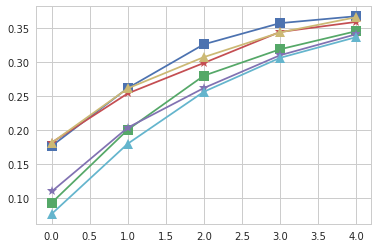

In [10]:
plt.plot(errors['proj_grad_asc_traces']['hamming_error_list'],marker = 's',markersize = 10)
plt.plot(errors['symbolwise_map_seq']['hamming_error_list'],marker = '*',markersize = 10)
plt.plot(errors['symbolwise_map_exact']['hamming_error_list'],marker = '^',markersize = 10)

In [ ]:
plt.plot(errors['symbolwise_map_seq']['hamming_error_list'])